In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os

Install Kaggle API

In [3]:
!pip install kaggle

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure permissions

# Download Caltech-256 dataset from Kaggle
!kaggle datasets download -d jessicali9530/caltech256

# Extract the dataset
import zipfile


dataset_path = "/content/caltech256.zip"
extract_path = "/content/256_ObjectCategories"

if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_path, "r") as zip_ref:
        zip_ref.extractall("/content/")
    print("Extraction complete!")


mv: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/caltech256
License(s): other
... resuming from 677380096 bytes (1599219302 bytes left) ...
 99% 2.10G/2.12G [00:10<00:00, 178MB/s]
100% 2.12G/2.12G [00:10<00:00, 149MB/s]
Extracting dataset...
Extraction complete!


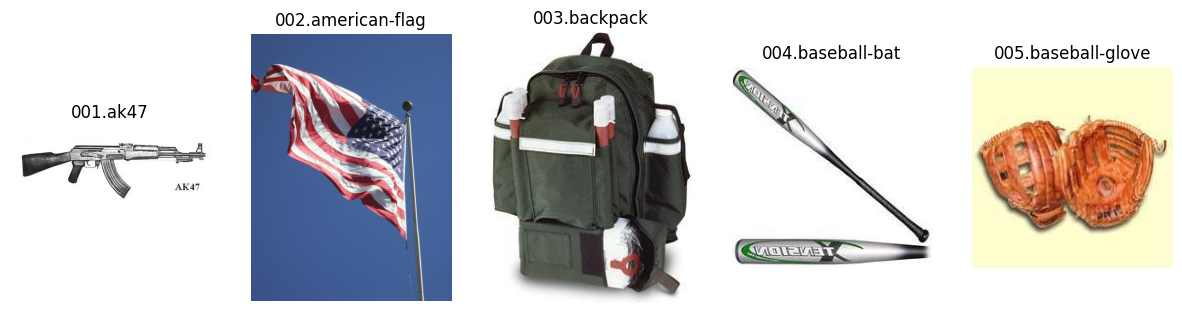

In [4]:
import os
import matplotlib.pyplot as plt
import cv2
import random

# Define dataset path
dataset_dir = "/content/256_ObjectCategories"

# Get class names
classes = sorted(os.listdir(dataset_dir))

# Display sample images
num_classes_to_show = 5
fig, axes = plt.subplots(1, num_classes_to_show, figsize=(15, 5))

for i in range(num_classes_to_show):
    class_name = classes[i]
    class_path = os.path.join(dataset_dir, class_name)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(class_name)

plt.show()


In [5]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMG_SIZE = 128
BATCH_SIZE = 32
DATASET_PATH = "./256_ObjectCategories"
TRAIN_PATH = "./data/train"
VAL_PATH = "./data/val"
TEST_PATH = "./data/test"

# Ensure directories exist
for path in [TRAIN_PATH, VAL_PATH, TEST_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

# Step 1: Move images into Train (70%), Validation (15%), and Test (15%) directories
for class_name in os.listdir(DATASET_PATH):
    class_dir = os.path.join(DATASET_PATH, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = os.listdir(class_dir)
    total_images = len(images)

    train_split = int(0.7 * total_images)
    val_split = int(0.15 * total_images)

    train_images = images[:train_split]
    val_images = images[train_split:train_split + val_split]
    test_images = images[train_split + val_split:]

    # Create class folders
    for split, split_images, split_path in zip(
        ["train", "val", "test"],
        [train_images, val_images, test_images],
        [TRAIN_PATH, VAL_PATH, TEST_PATH]
    ):
        class_split_path = os.path.join(split_path, class_name)
        os.makedirs(class_split_path, exist_ok=True)

        for img_name in split_images:
            shutil.move(os.path.join(class_dir, img_name), os.path.join(class_split_path, img_name))

print("Dataset split successfully!")

# Step 2: Load Data with ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse")
val_generator = datagen.flow_from_directory(VAL_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse")
test_generator = datagen.flow_from_directory(TEST_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse")

print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Dataset split successfully!
Found 21308 images belonging to 257 classes.
Found 4474 images belonging to 257 classes.
Found 4825 images belonging to 257 classes.
Train samples: 21308
Validation samples: 4474
Test samples: 4825


In [ ]:
import tensorflow as tf


# Define a simple model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model using generator (does NOT load everything in memory)
model.fit(train_generator, validation_data=val_generator, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


666/666 ━━━━━━━━━━━━━━━━━━━━ 55s 75ms/step - accuracy: 0.0264 - loss: 6.8680 - val_accuracy: 0.0981 - val_loss: 4.9335
Epoch 2/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 44s 66ms/step - accuracy: 0.1157 - loss: 4.6797 - val_accuracy: 0.1332 - val_loss: 4.5491
Epoch 3/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 47s 70ms/step - accuracy: 0.2005 - loss: 3.9306 - val_accuracy: 0.1549 - val_loss: 4.5049
Epoch 4/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 45s 66ms/step - accuracy: 0.3011 - loss: 3.2324 - val_accuracy: 0.1571 - val_loss: 4.6805
Epoch 5/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - accuracy: 0.4359 - loss: 2.4757 - val_accuracy: 0.1531 - val_loss: 5.0820


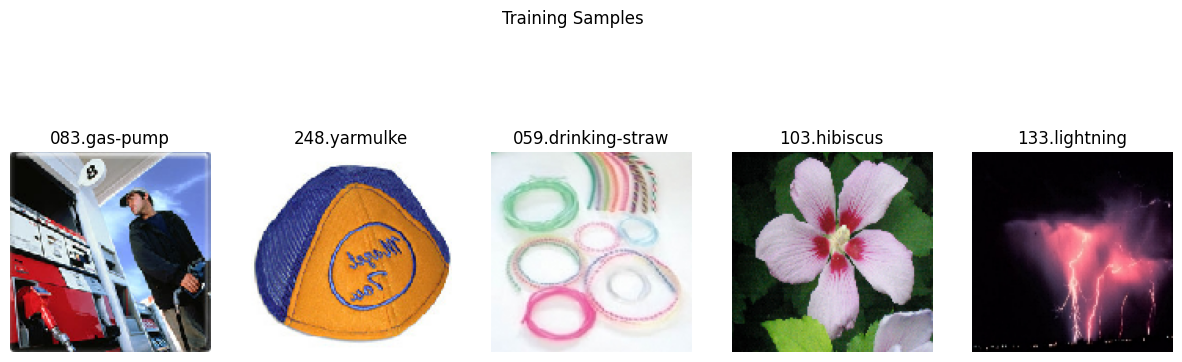

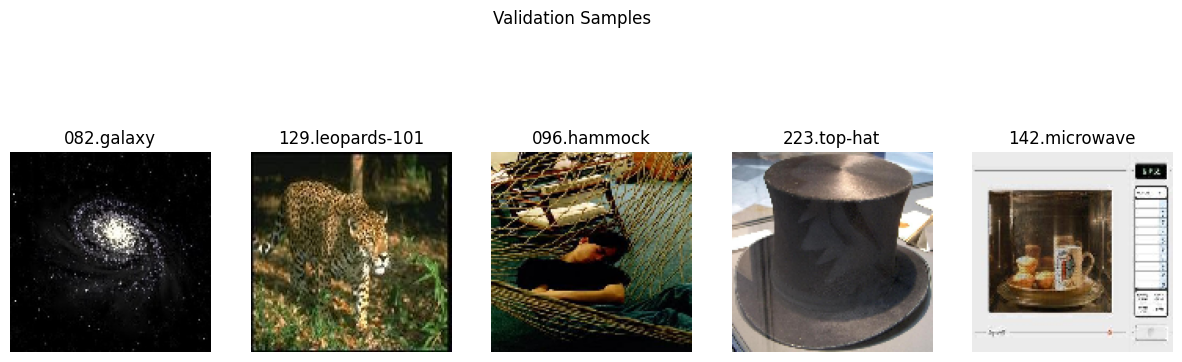

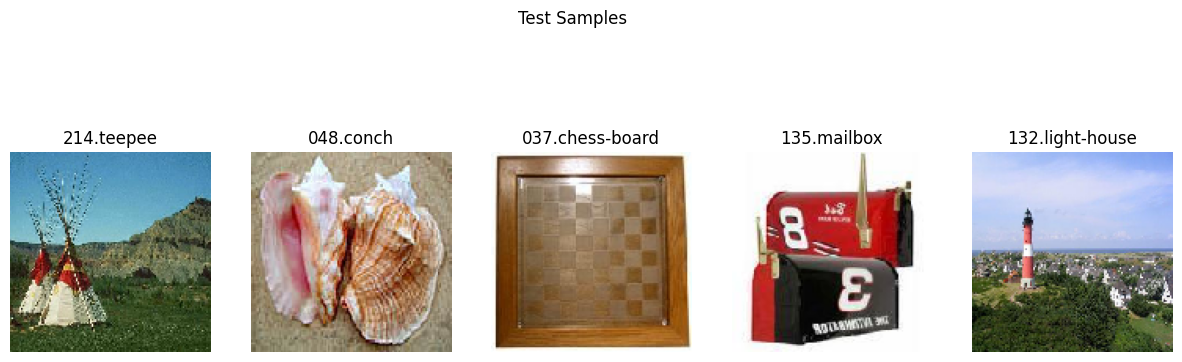

In [7]:


# Get class names
class_labels = list(train_generator.class_indices.keys())

# Function to display sample images
def plot_images(generator, title):
    images, labels = next(generator)  # Get one batch
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].axis("off")
        axes[i].set_title(class_labels[int(labels[i])])
    plt.suptitle(title)
    plt.show()

# Show images from train, validation, and test sets
plot_images(train_generator, "Training Samples")
plot_images(val_generator, "Validation Samples")
plot_images(test_generator, "Test Samples")


In [8]:

from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

loss_functions = {
    "cross_entropy": "sparse_categorical_crossentropy",
    "squared_error": "mse"
}

# Choose a loss function
selected_loss = loss_functions["squared_error"]
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 257)                 │         131,841 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,070,657 (49.86 MB)

 Trainable params: 13,070,657 (49.86 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define available optimizers
def get_optimizer(name, learning_rate=0.001):
    optimizers = {
        "sgd": tf.keras.optimizers.SGD(learning_rate=learning_rate),
        "momentum": tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
        "nesterov": tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
        "rmsprop": tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        "adam": tf.keras.optimizers.Adam(learning_rate=learning_rate),
        "nadam": tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    }
    return optimizers[name]

# Choose an optimizer
selected_optimizer = get_optimizer("adam", learning_rate=0.001)  # Change optimizer here

# Compile the model with the selected optimizer
model.compile(optimizer=selected_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Increase epochs for better results
    verbose=1
)


Epoch 1/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 60s 81ms/step - accuracy: 0.0499 - loss: 5.3430 - val_accuracy: 0.1460 - val_loss: 4.5016
Epoch 2/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 49s 73ms/step - accuracy: 0.1414 - loss: 4.4566 - val_accuracy: 0.2081 - val_loss: 3.9816
Epoch 3/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 48s 72ms/step - accuracy: 0.2205 - loss: 3.8449 - val_accuracy: 0.2501 - val_loss: 3.7338
Epoch 4/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 82s 72ms/step - accuracy: 0.2966 - loss: 3.2865 - val_accuracy: 0.2749 - val_loss: 3.6213
Epoch 5/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - accuracy: 0.3883 - loss: 2.7134 - val_accuracy: 0.2821 - val_loss: 3.6023
Epoch 6/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 49s 73ms/step - accuracy: 0.4947 - loss: 2.1258 - val_accuracy: 0.2763 - val_loss: 3.8500
Epoch 7/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 45s 68ms/step - accuracy: 0.5853 - loss: 1.6611 - val_accuracy: 0.2783 - val_loss: 4.0699
Epoch 8/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - accuracy: 0.6731 - loss: 1.2555 - 

In [10]:
# Evaluate model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")


140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.2542 - loss: 5.0594
Validation Accuracy: 0.2644, Validation Loss: 5.0111


In [11]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.2418 - loss: 5.2309
Test Accuracy: 0.2535, Test Loss: 5.1447


In [12]:
# Save the entire model
model.save("caltech256_cnn_model.h5")
print("Model saved successfully!")


Model saved successfully!


151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step


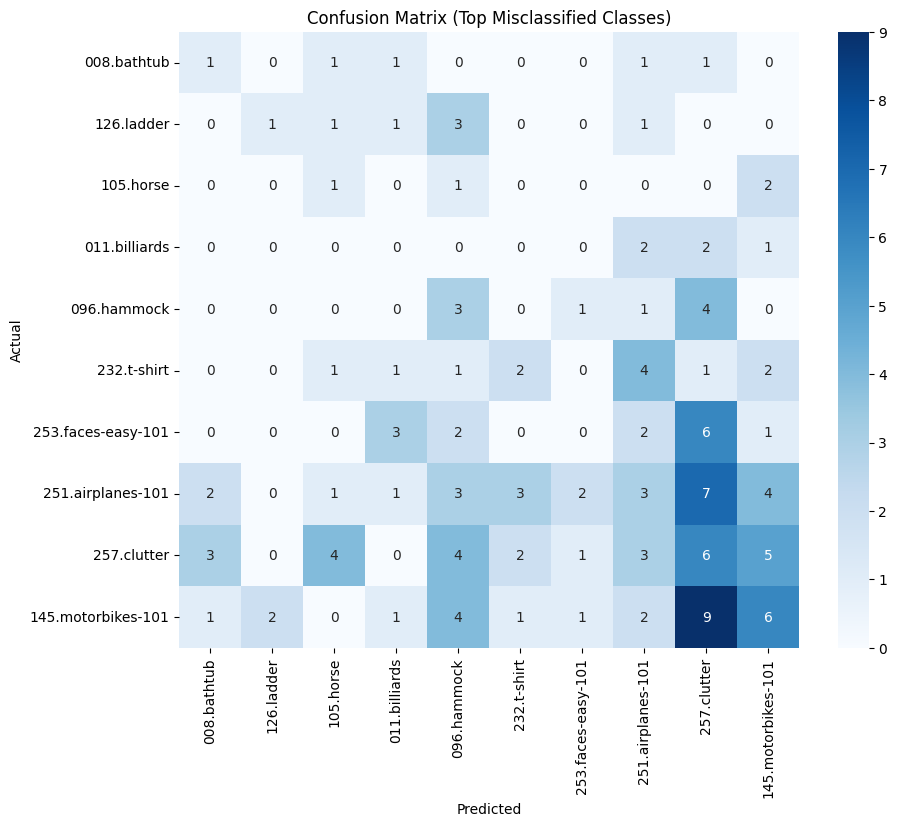

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
Y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(Y_true, y_pred)

# Get indices of most misclassified classes
least_correct = np.argsort(np.diag(cm))[:10]



# Filter confusion matrix for selected classes
cm_filtered = cm[np.ix_(misclassified, misclassified)]
class_labels_filtered = [class_labels[i] for i in misclassified]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_filtered, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels_filtered, yticklabels=class_labels_filtered)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Top Misclassified Classes)')
plt.show()
